******************Data overview:******************
  Professional         Country      University  \
0      Student   United States              No   
1      Student  United Kingdom  Yes, full-time   

                         EmploymentStatus  \
0  Not employed, and not looking for work   
1                      Employed part-time   

                                     FormalEducation         CompanySize  \
0                                   Secondary school                 NaN   
1  Some college/university study without earning ...  20 to 99 employees   

                                         CompanyType   YearsProgram  \
0                                                NaN   2 to 3 years   
1  Privately-held limited company, not in startup...  9 to 10 years   

  YearsCodedJob  CareerSatisfaction  JobSatisfaction  
0           NaN                   0                0  
1           NaN                   0                0  
*******************Data dtypes:*******************
  P

E:\Anaconda3_W12\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[1 1 0 ... 4 5 5]
[2 2 4 ... 5 3 3]
[6 2 7 ... 1 3 5]
[4 1 3 ... 6 7 2]
[5 1 8 ... 3 7 4]
*******K-mean value and silhouette summary:*******
[[ 6.          0.07767959]
 [ 7.          0.07585427]
 [ 8.          0.05898781]
 [ 9.          0.06222368]
 [10.          0.07001525]]
Best K is:6 with average silhouette of 0.0776796
*******Detailed features for all clusters:********


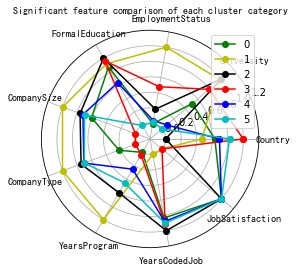

In [138]:
#After partition dataset into k clusters, what about developer distribution? 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier

# load dataset
out_dir = 'data/'
raw_data = pd.read_csv(out_dir + 'survey_results_public_less_features.csv', skiprows=1, low_memory=False)
raw_data2 = raw_data

# data review and verification
print('{:*^50}'.format('Data overview:'))
print(raw_data.head(2))  # print first two data rows
print('{:*^50}'.format('Data dtypes:'))
print(pd.DataFrame(raw_data.dtypes).T)  # print data distribution
print('{:*^50}'.format(' NA counts:'))
print(pd.DataFrame(raw_data.isnull().sum()).T)  # view missing data
print('{:*^50}'.format('Data DESC:'))
print(raw_data.describe().round(2).T)  # Print raw data basic descriptive information
print('{:*^50}'.format('Correlation analysis:'))
print(raw_data.corr().round(2).T)  # Print raw data correlation information

# String classification to integer classification
df = pd.DataFrame(raw_data2)
conver_cols = df.columns

convert_matrix = raw_data2[conver_cols]  # Get the all feature array to convert

for each_col in conver_cols:  # Convert by each column
    each_data = convert_matrix[each_col]  # Get each column data
    model_le = LabelEncoder()  # Builde model objects    
    
    if np.issubdtype(each_data.dtype, np.number):
        each_con_data = each_data.astype(str)
    else:
        each_con_data = model_le.fit_transform(each_data.astype(str))  # convert directly
        
    convert_matrix[each_col] = each_con_data  # Replace the original value with the converted value


#Handle OneHotEncode conversion for numeric index
model_onehotencode = OneHotEncoder(sparse=False)  # build OneHotEncode object
ohe_matrix = model_onehotencode.fit_transform(convert_matrix)  # convert directly

# Data standardization
scale_matrix = raw_data2.iloc[:, 1:11].select_dtypes(include=[np.number])  # Get the matrix to be converted

minmax_scaler = MinMaxScaler()  # build MinMaxScaler model object
data_scaled = minmax_scaler.fit_transform(scale_matrix)  # MinMaxScaler standardization

# Merge all input dimensions
X = np.hstack((data_scaled, ohe_matrix))

# The best KMeans clustering model is obtained by the average contour coefficient test.
mean_list = list()  # The tie contour coefficient used to store the model for each K
silhouette_int = -1  # Initialize average contour coefficient threshold
for n_clusters in range(6, len(conver_cols)):  # Traversing all features
    model_kmeans = KMeans(n_clusters=n_clusters)  # build object of clustering model
    cluster_labels_tmp = model_kmeans.fit_predict(X)  # train clustering model
    print(cluster_labels_tmp)
    silhouette_tmp = silhouette_score(X, cluster_labels_tmp)  # Get the average contour factor for each K
    if silhouette_tmp > silhouette_int:  # If the average contour factor is higher
        best_k = n_clusters  # Store the best K value
        silhouette_int = silhouette_tmp  # Store the best average contour score
        best_kmeans = model_kmeans  # Store the best model
        cluster_labels_k = cluster_labels_tmp  # Store the best clustering tags
    mean_list.append([n_clusters, silhouette_tmp])  # Append each time K and its score to the list
print('{:*^50}'.format('K-mean value and silhouette summary:'))
print(np.array(mean_list))  # Print out all the detailed scores under K
print('Best K is:{0} with average silhouette of {1}'.format(best_k, silhouette_int.round(7)))

# Feature analysis for clustering results
# prepare the label and data of training set
cluster_labels = pd.DataFrame(cluster_labels_k, columns=['clusters'])  # Get the label information under the training set
merge_data = pd.concat((convert_matrix, cluster_labels), axis=1)  # Integrate raw processed data with clustering tags

clustering_count = pd.DataFrame(
    merge_data['CareerSatisfaction'].groupby(merge_data['clusters']).count()).T.rename(
    {'CareerSatisfaction': 'counts'})  # Calculate the sample size for each cluster category
clustering_ratio = (clustering_count / len(merge_data)).round(2).rename(
    {'counts': 'percentage'})  # Calculate the proportion of sample size for each cluster category

cluster_features = []  # An empty list for storing all feature information after the final merge
for cluster_line in range(best_k):  # Read each class index        
    label_data = merge_data[merge_data['clusters'] == cluster_line]  # Get data for a specific class
    numeric_data1 = label_data.iloc[:, 1:10]  # Obtain numerical data features
    numeric_desc1 = numeric_data1.describe().round(3)  # Get descriptive statistics for numeric features    
    merge_data1 = numeric_desc1.iloc[2, :]  # Get the mean of the numerical features
    
    numeric_data2 = label_data.iloc[:, 10:-1]  # Get string data features
    numeric_desc2 = numeric_data2.describe(include='all')  # Get descriptive statistics for string data functionality
    merge_data2 = numeric_desc2.iloc[2, :]  # Get the most frequent values ​​of string data features

    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # Combine numeric and string typical features along the line
    merge_line.name = str(cluster_line)
    cluster_features.append(merge_line)  # Append data characteristics under each category to the list

kcluster_pd = pd.DataFrame(cluster_features).T  # Convert a list to a matrix
print('{:*^50}'.format('Detailed features for all clusters:'))
all_kcluster_set = pd.concat((clustering_count, clustering_ratio, kcluster_pd), axis=0)  # Combine all the information for each cluster category

# Significant numerical feature comparison of each category
num_cluster_sets = kcluster_pd.iloc[:10, :].T.astype(np.float64)  # Get the data to show
num_cluster_sets_max_min = minmax_scaler.fit_transform(num_cluster_sets)  # Obtain standardized data

fig = plt.figure()  # Building a canvas
ax = fig.add_subplot(111, polar=True)  # Increase the subgrid to the polar parameter
labels = np.array(merge_data1.index)  # Set the data labels to display
labels = np.concatenate((labels, ['JobSatisfaction'])) 
cor_list = [ 'g', 'y', 'k', 'r', 'b', 'c', 'w', 'm']  # Define different categories of colors
cluster_angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # Calculate the angle of each interval
cluster_angles = np.concatenate((cluster_angles, [cluster_angles[0]]))  # Create the same head and tail fields to close

for i in range(len(num_cluster_sets)):  # Loop each category
    data_tmp = num_cluster_sets_max_min[i, :]  # Get the corresponding class data
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # Create the same head and tail fields to close    
    ax.plot(cluster_angles, data, 'o-', c=cor_list[i], label=i)  # Draw lines

ax.set_thetagrids(cluster_angles * 180 / np.pi, labels, fontproperties="SimHei")  # Set the polar axis
ax.set_title("Significant feature comparison of each cluster category", fontproperties="SimHei")  # Set title
ax.set_rlim(-0.2, 1.5)  # Set the axis scale range
plt.legend(loc=0)  # Set the legend position
plt.show()  # Display image for clustering


In [129]:
# display features importance --Which features are more important for CareerSatisfaction？(show top 3)
names = raw_data2.columns
dataframe = convert_matrix
array = dataframe.values
featurenumber = len(raw_data2.columns)
X = array[:,0:featurenumber-2]
Y = array[:,featurenumber-1]
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
importance_value = model.feature_importances_
feature_index = np.array(importance_value).argpartition(-2)[-3:]
print(names[feature_index[0]])
print(names[feature_index[1]])
print(names[feature_index[2]])

E:\Anaconda3_W12\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CompanySize
YearsCodedJob
Country


                  Professional   Country  University  EmploymentStatus  \
Professional          1.000000 -0.042228    0.227068          0.464015   
Country              -0.042228  1.000000   -0.097353         -0.050928   
University            0.227068 -0.097353    1.000000          0.158026   
EmploymentStatus      0.464015 -0.050928    0.158026          1.000000   
FormalEducation       0.196680 -0.036936    0.130229          0.212228   
CompanySize           0.314229 -0.050818    0.079942          0.766421   
CompanyType           0.229019 -0.015193    0.018832          0.714361   
YearsProgram          0.024840 -0.012384    0.046750          0.024259   
YearsCodedJob         0.455354 -0.022106    0.124336          0.322851   

                  FormalEducation  CompanySize  CompanyType  YearsProgram  \
Professional             0.196680     0.314229     0.229019      0.024840   
Country                 -0.036936    -0.050818    -0.015193     -0.012384   
University               0.1

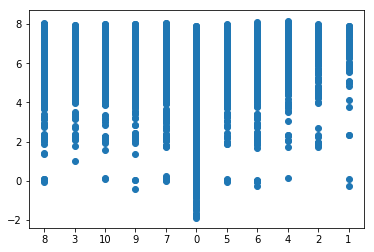

In [135]:
#verify those features are linear correlations -- These features are linear correlation or non-linear correlation?
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#split dataset and target
inpurt_train, input_test, output_train, output_test = train_test_split(X, Y, test_size=0.2, random_state=101)
lm = LinearRegression()
lm.fit(inpurt_train,output_train)
predictions = lm.predict(input_test)
print(dataframe.corr())
plt.scatter(y_test,predictions) # from the result, we can see those features are non-linear corelation